# PyTorch🔥CNN for MNIST Digits Classification

Subject: Building a CNN Classificator with PyTorch to classify hand-written digits.

Data: MNIST (handwritten digits) via torchvision

Procedure:
- Previewing images from dataset with pyplot's imshow()
- Neural network with torch.nn.module, torch.nn.Sequential, torch.nn.Conv2d, torch.nn.ReLU, torch.nn.MaxPool2d, torch.nn.Dropout, torch.nn.Linear, and torch.nn.init.xavier_uniform_
- Visualizing model with torchviz' make_dot()
- Training with nn.CrossEntropyLoss and torch.optim.Adam optimizer
- Visualization Loss and Accuracy with pyplot
- Visualization of the CNN Layers with pyplot's imshow()
- Good results

Others:
- CUDA support

Sources used:
- todo

## Bootstrap and Imports

In [1]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {DEVICE}')

if IN_COLAB := 'google.colab' in str(get_ipython()):
  NUM_EPOCHS = 100
  !pip install torchviz

else:
  NUM_EPOCHS = 2

Running on cuda


In [2]:
import random
from tqdm.auto import tqdm
import numpy as np
from collections.abc import Callable

from IPython.display import HTML, Image

import time
import matplotlib.animation as animation
import matplotlib.pyplot as plt
#%matplotlib inline

import torch
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision import utils
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torchviz import make_dot
import torch.nn.functional as F

my_seed = 123
random.seed(my_seed)
torch.manual_seed(my_seed)

In [3]:
def get_describe_only_once() -> Callable:
    already_described = set()

    def _describe_only_once(tensor: torch.Tensor, name: str):
        if name in already_described:
            return
        already_described.add(name)
        if hasattr(tensor, 'shape'):
            print(f"{name} is a {type(tensor)} of size {tensor.shape} with dtype {tensor.dtype}.")
        else:
            print(f"{name} is a {type(tensor)} with content {tensor}.")
    return _describe_only_once

describe_only_once = get_describe_only_once()

## Dataset

In [4]:
BATCH_SIZE = 128

In [5]:
# get mean and std. dev for normalization; also put from range 0..1255 to 0..1
dataset_tmp = datasets.MNIST('./data',
                             download=True,
                             train=True)  # dataset_tmp.data: [60000, 28, 28] torch.uint8
data = dataset_tmp.data.float()  # [60000, 28, 28] of dtype torch.uint8 -> torch.float32
mean = np.round(data.mean(axis=(0,1,2)).item()/255,4)  # numpy.float64
std = np.round(data.std(axis=(0,1,2)).item()/255,4)  # numpy.float64
print(f"mean: {mean}\nstd: {std}")  #

mean: 0.1307
std: 0.3081


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # normalize only the first tensor, i.e. x, not y
    # transforms.Normalize((mean,), (std,))  # (0.1307,), (0.3081,)
])

# download and save mnist at ./data
dataset_train = datasets.MNIST('./_tmp', download=True, train=True, transform=transform)  # dataset_train.data: [60000, 28, 28] torch.uint8
dataset_test = datasets.MNIST('./_tmp', download=True, train=False, transform=transform)  # dataset_test.data: [10000, 28, 28] torch.uint8

# there's probably a better way...
x_test_array = dataset_test.data.numpy()  # ndarray (10000, 28, 28) 'uint8'
x_test_ = transform(x_test_array)  # [28, 10000, 28]  torch.float32
x_test = x_test_.swapaxes(0, 1)  # 28, 10000, 28]  torch.float32
x_test = x_test.swapaxes(1, 2)  # 10000, 28, 28]  torch.float32
x_test = torch.unsqueeze(x_test, dim=1)  # [10000, 1, 28, 28]  torch.float32

y_test = dataset_test.targets  # [10000] torch.int64

# this would unfortunately result in cuda errors; we have to
# move to cuda in each batch run
# dataset_train.data = dataset_train.data.to(DEVICE)
# dataset_train.targets = dataset_train.targets.to(DEVICE)

train_loader = DataLoader(dataset_train,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

## DataLoader

In [7]:
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

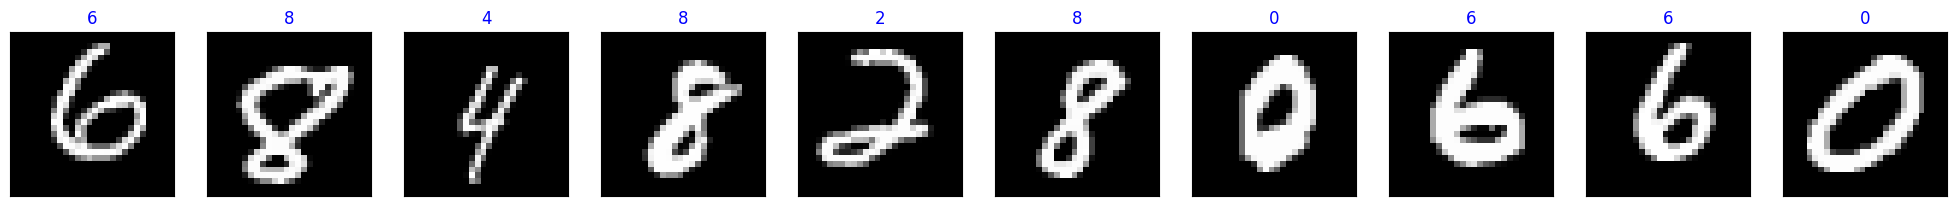

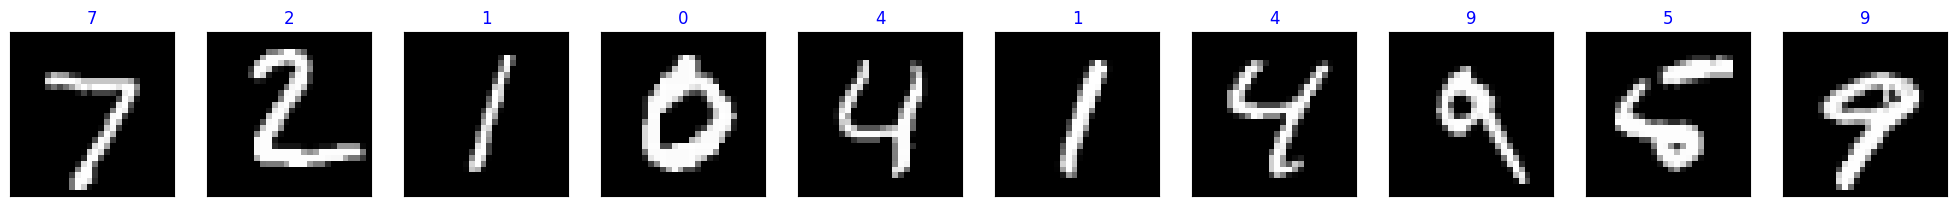

In [8]:
# preview first ten images
def print_ten_numbers(x: torch.Tensor, y: torch.Tensor):
    fig = plt.figure(figsize=(25, 10))  # (width, height) in inches
    for i in range(10):
        ax = fig.add_subplot(1,         # nrows
                             10,        # ncols
                             i+1,       # index (1-based)
                             xticks=[],
                             yticks=[])
        image = x[i]  # [1, 28, 28]
        # image_numpy_squeezed = image.numpy().squeeze()  # <class 'numpy.ndarray'> of size (28, 28)  # conversion to ndarry not required(anymore).
        label = y[i].item()  # int
        ax.imshow(X=image.squeeze(),
                  cmap='gray')
        ax.set_title(f"{label}", color=("blue"))

# train
x_batch, y_batch = next(iter(train_loader))   # x_batch: [128, 1, 28, 28] torch.float32, y_batch: [128] torch.int64

print_ten_numbers(x=x_batch, y=y_batch)

# test
print_ten_numbers(x=x_test, y=y_test)


In [9]:
# preview first image data
# print(x_batch[0])
# print(y_batch[0])

## CNN Classifier

In [10]:
class CNNClassifier(torch.nn.Module):
    # https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/

    def __init__(self, dropout_probability=0.3):
        super(CNNClassifier, self).__init__()
        self.layer1 = torch.nn.Sequential(
            # (?, 1, 28, 28) -> (?, 32, 28, 28)
            torch.nn.Conv2d(in_channels=1,  # Number of channels in the input image
                            out_channels=32,  # Number of channels produced by the convolution
                            kernel_size=3, #  Size of the convolving kernel
                            stride=1,  # Stride of the convolution. Default: 1
                            padding=1,  # Padding added to all four sides of the input. Default: 0
                           ),
            # (element-wise)
            torch.nn.ReLU(),
            # (?, 32, 28, 28)  - > (?, 32, 14, 14)
            torch.nn.MaxPool2d(kernel_size=2, # the size of the window to take a max over
                               stride=2,  # the stride of the window. Default value is kernel_size
                              ),
            # (element-wise)
            torch.nn.Dropout(p=dropout_probability,  # probability of an element to be zeroed. Default: 0.5
                            ),
        )

        self.layer2 = torch.nn.Sequential(
            # (?, 32, 14, 14) --> (?, 64, 14, 14)
            torch.nn.Conv2d(in_channels=32,
                            out_channels=64,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.ReLU(),
            # (?, 64, 14, 14) --> (?, 64, 7, 7)
            torch.nn.MaxPool2d(kernel_size=2,
                               stride=2),
            torch.nn.Dropout(p=dropout_probability))

        self.layer3 = torch.nn.Sequential(
            # (?, 64, 7, 7) --> (?, 128, 7, 7)
            torch.nn.Conv2d(in_channels=64,
                            out_channels=128,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.ReLU(),
            # (?, 128, 7, 7) --> (?, 128, 4, 4)
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=dropout_probability))

        # [128, 2048] --> [128, 625]
        self.fc1 = torch.nn.Linear(in_features=4 * 4 * 128,
                                   out_features=625,
                                   bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)  # initialize weights

        # [128, 625] --> [128, 10]
        self.fc2 = torch.nn.Linear(in_features=625,
                                   out_features=10,
                                   bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)  # initialize weights

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # x: [128, 1, 28, 28]
        # plt.imshow(x[0][0].detach(), cmap='gray')
        output_layer_1 = self.layer1(x)  # [128, 32, 14, 14]
        # plt.imshow(output_layer_1[0][0].detach(), cmap='gray')
        output_layer_2 = self.layer2(output_layer_1)  # [128, 64, 7, 7]
        #plt.imshow(output_layer_2[0][0].detach(), cmap='gray')
        output_layer_3 = self.layer3(output_layer_2)  # [128, 128, 4, 4]
        #plt.imshow(output_layer_3[0][0].detach(), cmap='gray')

        # flatten for FC
        output_layer_3_flattened = output_layer_3.view(output_layer_3.size(0), -1)  # [128, 2048]
        output_fully_connected_1 = self.fc1(output_layer_3_flattened)  # [128, 625]
        output_fully_connected_2 = self.fc2(output_fully_connected_1)  # [128, 10]

        return output_fully_connected_2

Predictions:
 tensor([[-0.3773, -0.2486, -0.1195,  ..., -0.2461,  0.0771, -0.0485],
        [-0.2822, -0.3524, -0.2194,  ..., -0.1572, -0.2344,  0.0295],
        [-0.0039, -0.0463, -0.1155,  ...,  0.0990,  0.0648, -0.1825],
        ...,
        [ 0.0375, -0.0506, -0.0700,  ...,  0.1151, -0.0897, -0.2503],
        [-0.0845, -0.2083, -0.3950,  ..., -0.3214,  0.1079,  0.0946],
        [-0.2327, -0.1756, -0.1213,  ..., -0.1013,  0.1515, -0.1617]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted Labels:
 tensor([4, 4, 5, 8, 4, 8, 4, 4, 4, 5, 4, 8, 4, 5, 4, 4, 4, 5, 4, 4, 5, 5, 6, 4,
        5, 5, 4, 4, 5, 4, 4, 5, 4, 5, 5, 4, 4, 5, 4, 4, 5, 5, 8, 5, 4, 4, 5, 4,
        1, 4, 5, 5, 6, 4, 5, 4, 5, 5, 4, 9, 4, 4, 5, 8, 5, 5, 4, 5, 4, 6, 4, 4,
        5, 9, 5, 5, 3, 5, 4, 5, 4, 5, 5, 4, 4, 5, 5, 5, 4, 4, 5, 5, 4, 8, 4, 4,
        5, 6, 5, 4, 5, 4, 5, 4, 4, 5, 5, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 5, 5,
        5, 5, 4, 6, 4, 4, 5, 5], device='cuda:0')


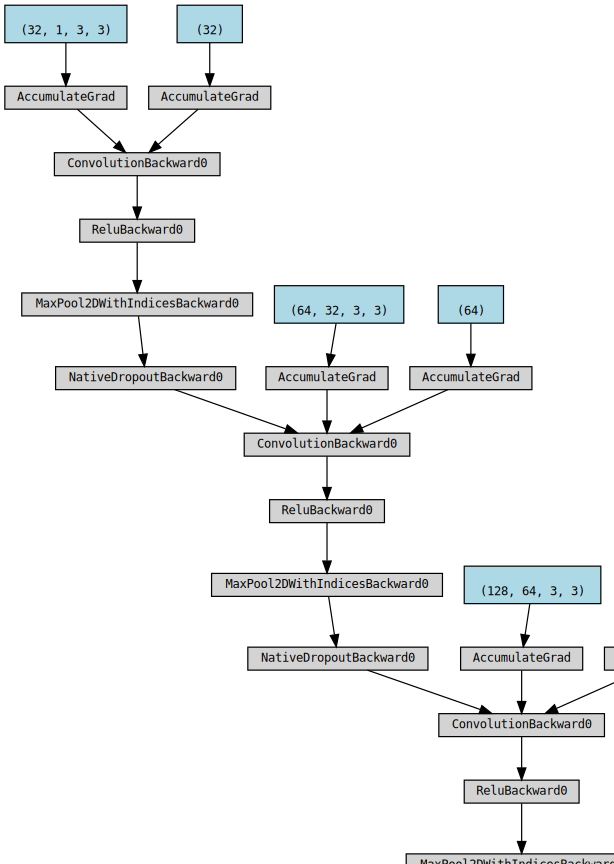

In [11]:
# visualize the classifier
c_temp = CNNClassifier().to(DEVICE)
# to visualize with torchviz, we need some input that can pass through the model's forward() method.
predictions = c_temp(x_batch.to(DEVICE))
print('Predictions:\n', predictions)
predicted_labels = predictions.argmax(dim=1,
                                      keepdim=False)  # get the index of the max log-probability
print('Predicted Labels:\n', predicted_labels)

make_dot(predictions)

## Training

In [12]:
DISPLAY_EVERY_N_STEPS = 10
LEARNING_RATE = 0.001

classifier = CNNClassifier().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(),
                             lr = LEARNING_RATE)

In [13]:
def get_accuracy(pred_logits, targets) -> float:
    # pred_logits: [10000, 10] torch.float32
    # targets: [10000] torch.int64

    pred_labels = torch.argmax(pred_logits,
                               dim=1)  # [10000] torch.int64
    correct = (pred_labels == targets)  # [10000] torch.bool
    count_correct = correct.sum()  # []

    accuracy_ = count_correct / len(correct)  # [] torch.float32
    accuracy = accuracy_.item()  # 'float', e.g. 0.9630000114440918 (--> 9.6%)
    return accuracy

In [16]:
total_steps = NUM_EPOCHS * len(train_loader.dataset)
loss_history = []
accuracy_train_history = []
accuracy_test_history = []
current_step = 0

for epoch in tqdm(range(NUM_EPOCHS)):

    for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):
        # x_train_batch: [128, 1, 28, 28] torch.float32
        # y_train_batch: [128] torch.int64

        x_train_batch = x_train_batch.to(DEVICE)
        y_train_batch = y_train_batch.to(DEVICE)

        # switch to training mode mode (we might have been in evaluation mode)
        classifier.train()

        pred_train_batch = classifier(x_train_batch)  # [128, 10]

        # clear existing gradients from previous batch
        optimizer.zero_grad()

        loss = loss_fn(pred_train_batch,
                       y_train_batch)  # [], .item() is e.g. 2.291177988052368
        loss_history.append(loss.item())

        # compute gradients (backpropagation), then apply gradients
        loss.backward()
        optimizer.step()

        # switch to evaluation mode, then evaluate without computing gradients
        classifier.eval()
        with torch.no_grad():
            pred_test = classifier(x_test.to(DEVICE))  # [10000, 10] torch.float32
            accuracy_test = get_accuracy(pred_logits=pred_test,
                                         targets=y_test.to(DEVICE))
            accuracy_test_history.append(accuracy_test)

            accuracy_train = get_accuracy(pred_logits=pred_train_batch,
                                          targets=y_train_batch)
            accuracy_train_history.append(accuracy_train)

        if current_step % DISPLAY_EVERY_N_STEPS == 0:
            print(f'Accuracy Train in epoch {epoch} / batch {batch}: {accuracy_train}')
            print(f'Accuracy Test in epoch {epoch} / batch {batch}: {accuracy_test}\n')

        current_step += 1

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy Train in epoch 0 / batch 0: 0.203125
Accuracy Test in epoch 0 / batch 0: 0.20749999582767487

Accuracy Train in epoch 0 / batch 10: 0.4296875
Accuracy Test in epoch 0 / batch 10: 0.6150000095367432

Accuracy Train in epoch 0 / batch 20: 0.7109375
Accuracy Test in epoch 0 / batch 20: 0.7763999700546265

Accuracy Train in epoch 0 / batch 30: 0.6953125
Accuracy Test in epoch 0 / batch 30: 0.8531999588012695

Accuracy Train in epoch 0 / batch 40: 0.84375
Accuracy Test in epoch 0 / batch 40: 0.8935999870300293

Accuracy Train in epoch 0 / batch 50: 0.9140625
Accuracy Test in epoch 0 / batch 50: 0.9196999669075012

Accuracy Train in epoch 0 / batch 60: 0.875
Accuracy Test in epoch 0 / batch 60: 0.9311999678611755

Accuracy Train in epoch 0 / batch 70: 0.90625
Accuracy Test in epoch 0 / batch 70: 0.941100001335144

Accuracy Train in epoch 0 / batch 80: 0.859375
Accuracy Test in epoch 0 / batch 80: 0.9478999972343445

Accuracy Train in epoch 0 / batch 90: 0.921875
Accuracy Test in epo

KeyboardInterrupt: ignored

## Visualization of Accuracy and Loss

Text(0.5, 0, 'steps')

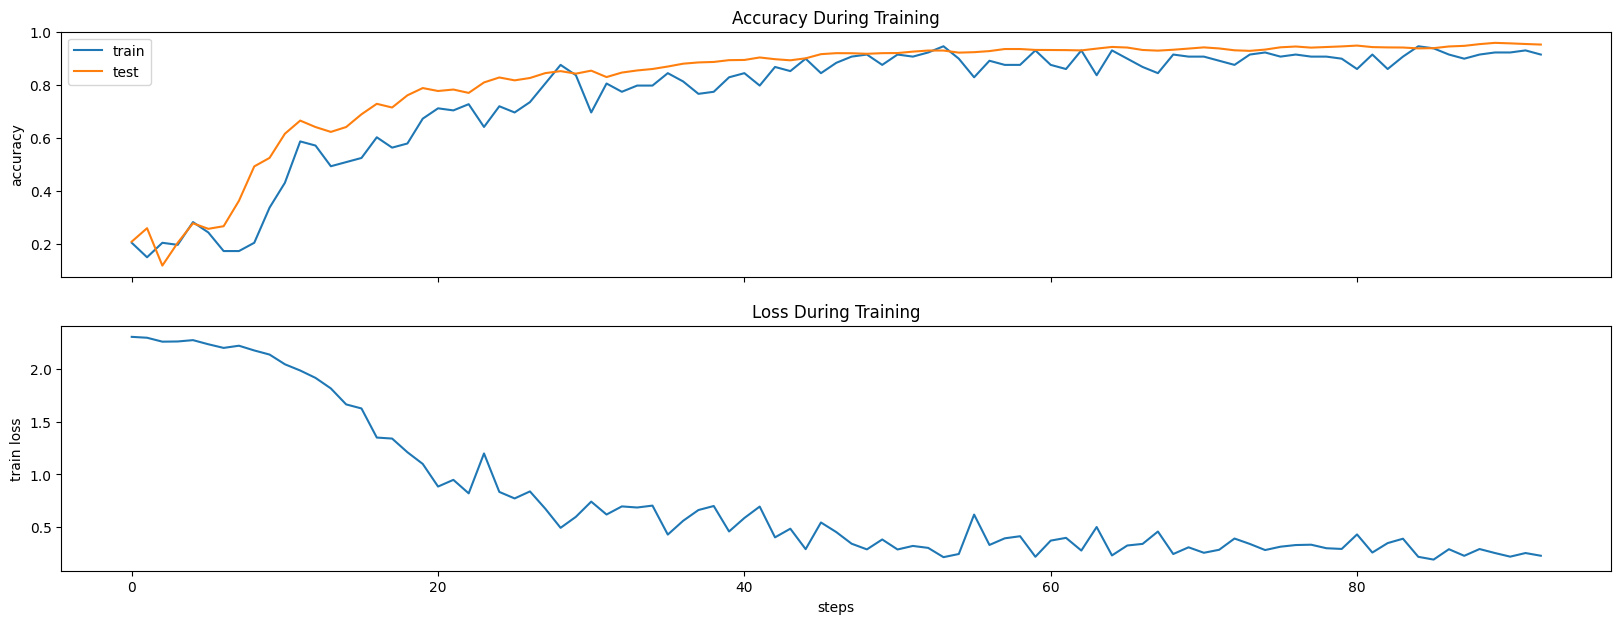

In [17]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 7), sharex=True)

ax1.set_title("Accuracy During Training")
ax1.plot(accuracy_train_history, label='train')
ax1.set_ylabel("accuracy")
ax1.plot(accuracy_test_history, label='test')
ax1.set_ylabel("accuracy")
ax1.legend()

ax2.set_title("Loss During Training")
ax2.plot(loss_history)
ax2.set_ylabel("train loss")
ax2.set_xlabel("steps")

## Visualization of CNN Layers

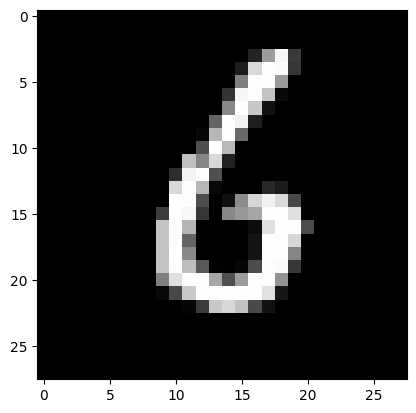

In [18]:
# let's look at an example image from the test dataset:
# classifier(x_test)  # [10000, 10] torch.float32
n_example = 50
x_example = x_test[n_example].detach()  # (1, 28, 28)
x_example_as_batch = x_example.unsqueeze(0)  # [1, 1, 28, 28]
x_example_as_image = x_example[0]  # (28, 28)

y_example = y_test[n_example].detach()  # e.g. tensor(0)
plt.imshow(x_example_as_image, cmap='gray')

In [23]:
# the final prediction is...
classifier.eval()
with torch.no_grad():
    predicted_logits = classifier(x_example_as_batch.to(DEVICE))  # [1, 10]
    for i in range(10):
        print(f'{i}: {round(predicted_logits[0][i].item(), 2) :5}')

0:  2.33
1:  0.87
2:  0.79
3: -0.96
4: -0.83
5:  0.87
6:  9.03
7: -6.31
8: -0.17
9: -3.75


### Show the outputs of CNN Layer 1

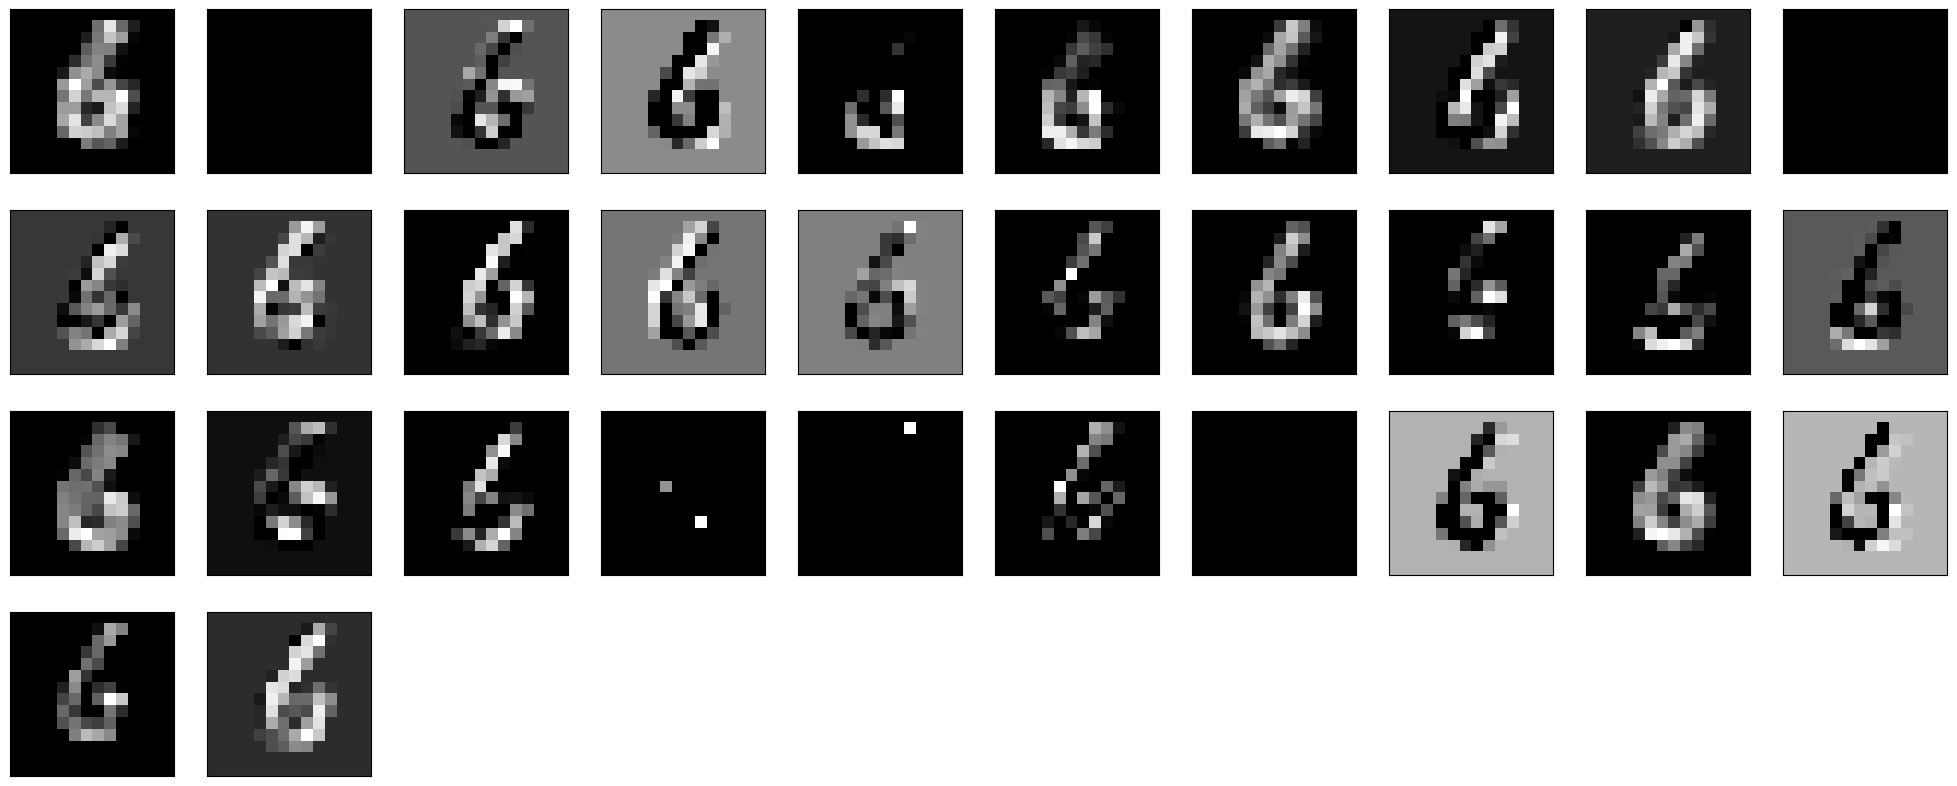

In [28]:
output_layer_1 = classifier.layer1(
    x_example_as_batch.to(DEVICE)
    ).detach()  # 1, 32, 14, 14

fig = plt.figure(figsize=(25, 10))  # (width, height) in inches
for i in range(32):
    ax = fig.add_subplot(4,         # nrows
                 10,        # ncols
                 i+1,       # index (1-based)
                 xticks=[],
                 yticks=[])
    image = output_layer_1[0][i]  # (14, 14)
    ax.imshow(X=image.cpu(),
              cmap='gray')

### Show the outputs of CNN Layer 2

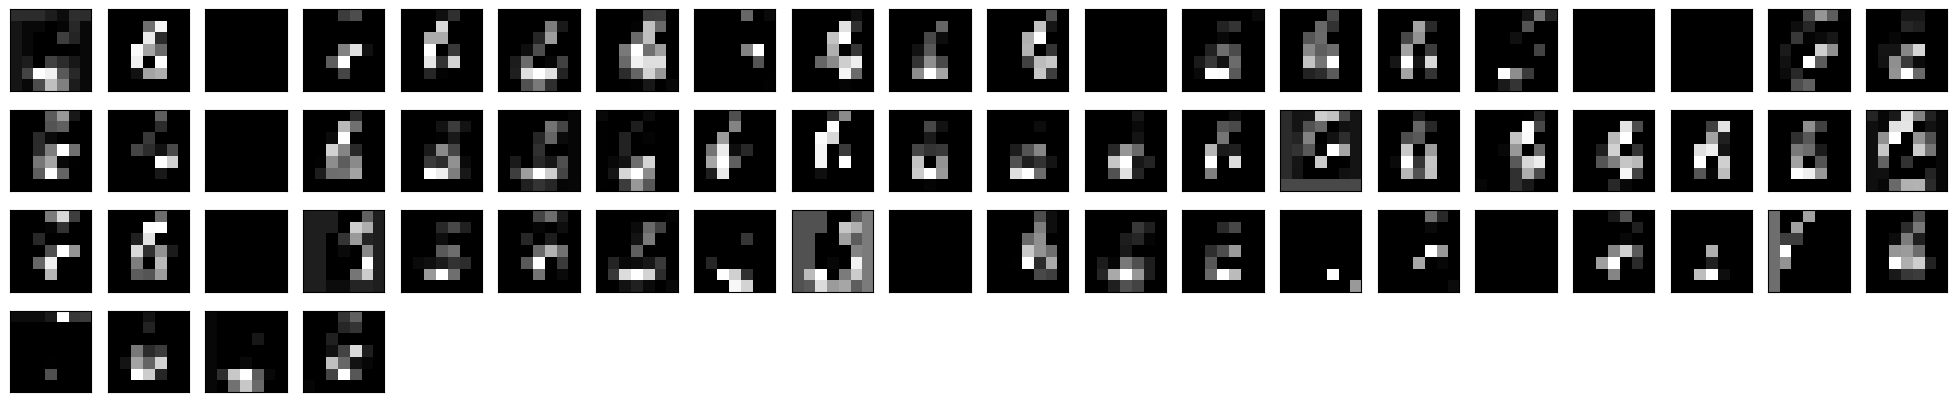

In [29]:
output_layer_2 = classifier.layer2(output_layer_1.to(DEVICE)).detach()  # [1, 64, 7, 7]

fig = plt.figure(figsize=(25, 5))  # (width, height) in inches
for i in range(64):
    ax = fig.add_subplot(
                 4,         # nrows
                 20,        # ncols
                 i+1,       # index (1-based)
                 xticks=[],
                 yticks=[])
    image = output_layer_2[0][i]  # (7, 7)
    ax.imshow(X=image.cpu(),
              cmap='gray')

### Show the outputs of CNN Layer 3

torch.Size([1, 128, 4, 4])


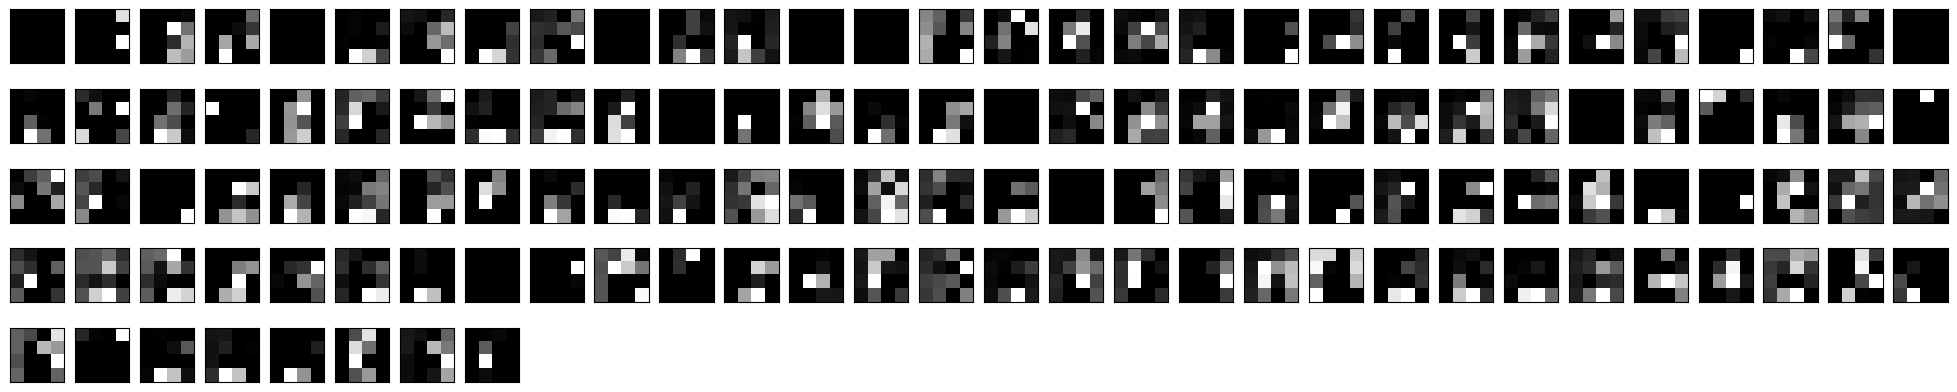

In [30]:
output_layer_3 = classifier.layer3(output_layer_2.to(DEVICE)).detach()  # [1, 128, 4, 4]
print(output_layer_3.shape)

fig = plt.figure(figsize=(25, 5))  # (width, height) in inches
for i in range(128):
    ax = fig.add_subplot(
                 5,         # nrows
                 30,        # ncols
                 i+1,       # index (1-based)
                 xticks=[],
                 yticks=[])
    image = output_layer_3[0][i]  # (28, 28)
    ax.imshow(X=image.cpu(),
              cmap='gray')